<a href="https://colab.research.google.com/github/santoshkumarbvp/Kaggle/blob/main/Stock_prediction_from_news_headlines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting the Dow Jones with News

The goal of this project is to use the top, daily news headlines from Reddit to predict the movement of the Dow Jones Industrial Average. The data for this project spans from 2008-08-08 to 2016-07-01, and is from this [Kaggle dataset](https://www.kaggle.com/aaron7sun/stocknews). 

The news from a given day will be used to predict the difference in opening price between that day, and the following day. This method is chosen because it should allow all of the day's news to be incorporated into the price compared to closing price, which could only incorporate the day's morning and afternoon news.

For this project, we will use GloVe to create our word embeddings and CNNs followed by LSTMs to build our model. This model is based off the work done in this paper https://www.aclweb.org/anthology/C/C16/C16-1229.pdf.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dropout, Activation, Embedding, Convolution1D, MaxPooling1D, Input, Dense, \
                         BatchNormalization, Flatten, Reshape, Concatenate
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras import regularizers

In [10]:
dj = pd.read_csv("/content/drive/MyDrive/DowJones.csv")
news = pd.read_csv("/content/drive/MyDrive/News.csv", sep=",")

## Inspect the data

In [11]:
dj.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [12]:
dj.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [13]:
news.isnull().sum()

Date    0
News    0
dtype: int64

In [14]:
news.head()

,Date,News
0,2016-07-01,A 117-year-old woman in Mexico City finally re...
1,2016-07-01,IMF chief backs Athens as permanent Olympic host
2,2016-07-01,"The president of France says if Brexit won, so..."
3,2016-07-01,British Man Who Must Give Police 24 Hours' Not...
4,2016-07-01,100+ Nobel laureates urge Greenpeace to stop o...


In [15]:
print(dj.shape)
print(news.shape)

(1989, 7)
(73608, 2)


In [16]:
# Compare the number of unique dates. We want matching values.
print(len(set(dj.Date)))
print(len(set(news.Date)))

1989
2943


In [17]:
# Remove the extra dates that are in news
news = news[news.Date.isin(dj.Date)]

In [18]:
print(len(set(dj.Date)))
print(len(set(news.Date)))

1989
1989


In [19]:
dj.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2016-07-01,17924.240234,18002.380859,17916.910156,17949.369141,82160000,17949.369141
1,2016-06-30,17712.759766,17930.609375,17711.800781,17929.990234,133030000,17929.990234
2,2016-06-29,17456.019531,17704.509766,17456.019531,17694.679688,106380000,17694.679688
3,2016-06-28,17190.509766,17409.720703,17190.509766,17409.720703,112190000,17409.720703
4,2016-06-27,17355.210938,17355.210938,17063.080078,17140.240234,138740000,17140.240234


In [20]:
# Calculate the difference in opening prices between the following and current day.
# The model will try to predict how much the Open value will change beased on the news.
dj = dj.set_index('Date').diff(periods=1)
dj['Date'] = dj.index
dj = dj.reset_index(drop=True)
# Remove unneeded features
dj = dj.drop(['High','Low','Close','Volume','Adj Close'], 1)

In [21]:
dj.head(), dj.shape

(         Open        Date
 0         NaN  2016-07-01
 1 -211.480468  2016-06-30
 2 -256.740235  2016-06-29
 3 -265.509765  2016-06-28
 4  164.701172  2016-06-27, (1989, 2))

In [22]:
# Remove top row since it has a null value.
dj = dj[dj.Open.notnull()]

In [23]:
dj.shape

(1988, 2)

In [24]:
# Check if there are any more null values.
dj.isnull().sum()

Open    0
Date    0
dtype: int64

In [25]:
news.shape, dj.shape

((49718, 2), (1988, 2))

In [26]:
# Create a list of the opening prices and their corresponding daily headlines from the news
price = []
headlines = []

for row in dj.iterrows():
    daily_headlines = []
    date = row[1]['Date']
    price.append(row[1]['Open'])
    for row_ in news[news.Date==date].iterrows():
        daily_headlines.append(row_[1]['News'])
    
    # Track progress
    headlines.append(daily_headlines)
    if len(price) % 500 == 0:
        print(len(price))

500
1000
1500


In [27]:
# Compare lengths to ensure they are the same
print(len(price))
print(len(headlines))

1988
1988


In [28]:
# Compare the number of headlines for each day
print(max(len(i) for i in headlines))
print(min(len(i) for i in headlines))
print(np.mean([len(i) for i in headlines]))

25
22
24.996478873239436


In [29]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [30]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'0,0', '00', text) 
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Optionally, remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [32]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [33]:
# Clean the headlines
clean_headlines = []

for daily_headlines in headlines:
    clean_daily_headlines = []
    for headline in daily_headlines:
        clean_daily_headlines.append(clean_text(headline))
    clean_headlines.append(clean_daily_headlines)

In [34]:
# Take a look at some headlines to ensure everything was cleaned well
len(clean_headlines)

1988

In [35]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

for date in clean_headlines:
    for headline in date:
        for word in headline.split():
            if word not in word_counts:
                word_counts[word] = 1
            else:
                word_counts[word] += 1
            
print("Size of Vocabulary:", len(word_counts))

Size of Vocabulary: 35190


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
#drive.flush_and_unmount()

In [36]:
# Load GloVe's embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings:', len(embeddings_index))

Word embeddings: 400000


In [37]:
embeddings_index['fish']

array([-0.65654 ,  0.56149 ,  0.43801 , -0.70816 , -0.02848 , -0.541   ,
        0.32885 ,  0.19502 ,  0.064846, -1.3596  , -0.58534 ,  0.4832  ,
        0.33913 ,  0.35244 ,  0.014004,  0.20392 ,  0.26975 , -0.052985,
       -0.35107 ,  0.78838 ,  0.28599 ,  0.41146 ,  0.71163 , -0.33233 ,
        0.76987 ,  1.2209  , -0.43528 , -0.79026 , -0.30152 ,  0.54479 ,
       -0.6672  ,  0.29536 , -0.12011 , -0.048952,  0.45108 ,  0.14186 ,
       -0.63951 ,  0.14591 ,  0.4785  , -0.8323  , -0.17478 , -1.5759  ,
       -0.8885  , -0.43423 ,  1.0733  ,  0.45304 , -0.51571 , -0.20244 ,
       -0.74595 , -0.36699 ,  0.22531 , -0.16772 , -0.12776 ,  0.7057  ,
       -0.61219 , -0.93637 , -0.10686 , -0.63908 ,  1.1557  ,  0.66294 ,
       -0.42806 ,  0.60697 ,  0.74073 ,  0.28582 ,  1.14    ,  0.18724 ,
       -0.051093, -0.33439 ,  0.72001 , -0.44025 , -0.036515,  0.060187,
        1.0262  ,  0.69332 , -0.26809 ,  0.21283 , -1.3187  , -0.30737 ,
        0.21162 ,  1.0292  ,  0.68704 , -0.25537 , 

In [38]:
# Find the number of words that are missing from GloVe, and are used more than our threshold.
missing_words = 0
threshold = 10

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from GloVe:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

Number of words missing from GloVe: 41
Percent of words that are missing from vocabulary: 0.12%


In [40]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1

# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total Number of Unique Words:", len(word_counts))
print("Number of Words we will use:", len(vocab_to_int))
print("Percent of Words we will use: {}%".format(usage_ratio))

Total Number of Unique Words: 35190
Number of Words we will use: 31808
Percent of Words we will use: 90.39%


In [41]:
# Need to use 300 for embedding dimensions to match GloVe's vectors.
embedding_dim = 100

nb_words = len(vocab_to_int)
# Create matrix with default values of zero
word_embedding_matrix = np.zeros((nb_words, embedding_dim))
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in GloVe, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding

# Check if value matches len(vocab_to_int)
print(len(word_embedding_matrix))

31808


In [42]:
len(embeddings_index) # 51 new embedding is added.

400051

In [ ]:
vocab_to_int['king']

602

In [43]:
word_embedding_matrix.shape

(31808, 100)

In [44]:
word_embedding_matrix[vocab_to_int['king']]

array([-0.32306999, -0.87616003,  0.21977   ,  0.25268   ,  0.22976001,
        0.73879999, -0.37954   , -0.35306999, -0.84368998, -1.11129999,
       -0.30265999,  0.33177999, -0.25113001,  0.30447999, -0.077491  ,
       -0.89815003,  0.092496  , -1.14069998, -0.58323997,  0.66869003,
       -0.23122001, -0.95854998,  0.28262001, -0.078848  ,  0.75314999,
        0.26583999,  0.34220001, -0.33949   ,  0.95608002,  0.065641  ,
        0.45747   ,  0.39835   ,  0.57964998,  0.39267001, -0.21851   ,
        0.58794999, -0.55998999,  0.63367999, -0.043983  , -0.68730998,
       -0.37841001,  0.38025999,  0.61641002, -0.88269001, -0.12346   ,
       -0.37928   , -0.38317999,  0.23868001,  0.66850001, -0.43320999,
       -0.11065   ,  0.081723  ,  1.15690005,  0.78957999, -0.21223   ,
       -2.3211    , -0.67806   ,  0.44560999,  0.65706998,  0.1045    ,
        0.46217   ,  0.19912   ,  0.25802001,  0.057194  ,  0.53443003,
       -0.43133   , -0.34311   ,  0.59789002, -0.58416998,  0.06

Note: The embeddings will be updated as the model trains, so our new 'random' embeddings will be more accurate by the end of training. This is also why we want to only use words that appear at least 10 times. By having the model see the word numerous timesm it will be better able to understand what it means. 

In [ ]:
# [len(j) for i in clean_headlines for j in i ] # list of list

In [45]:
len(clean_headlines)

1988

In [49]:
# Change the text from words to integers
# If word is not in vocab, replace it with <UNK> (unknown)
word_count = 0
unk_count = 0

int_headlines = []

for date in clean_headlines:
    int_daily_headlines = []
    for headline in date:
        int_headline = []
        for word in headline.split():
            word_count += 1
            if word in vocab_to_int:
                int_headline.append(vocab_to_int[word])
            else:
                int_headline.append(vocab_to_int["<UNK>"])
                unk_count += 1
        int_daily_headlines.append(int_headline)
    int_headlines.append(int_daily_headlines)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in headlines:", word_count)
print("Total number of UNKs in headlines:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

Total number of words in headlines: 615989
Total number of UNKs in headlines: 4285
Percent of words that are UNK: 0.7000000000000001%


In [50]:
[int_to_vocab[i] for i in int_headlines[1987][0]]

['b',
 'georgia',
 'downs',
 'two',
 'russian',
 'warplanes',
 'countries',
 'move',
 'brink',
 'war']

In [ ]:
len(int_headlines[1987][10])

15

In [ ]:
clean_headlines[1987][0]

'b georgia downs two russian warplanes countries move brink war'

In [ ]:
int_headlines[0][0]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [51]:
# Find the length of headlines
lengths = []
for date in int_headlines:
    for headline in date:
        lengths.append(len(headline))

# Create a dataframe so that the values can be inspected
lengths = pd.DataFrame(lengths, columns=['counts'])

In [ ]:
lengths.shape

(49693, 1)

In [91]:
# Limit the length of a day's news to 200 words, and the length of any headline to 16 words.
# These values are chosen to not have an excessively long training time and 
# balance the number of headlines used and the number of words from each headline.
max_headline_length = 16
max_daily_length = 200
pad_headlines = []

for date in int_headlines:
    pad_daily_headlines = []
    for headline in date:
        # Add headline if it is less than max length
        if len(headline) <= max_headline_length:
            for word in headline:
                pad_daily_headlines.append(word)
        # Limit headline if it is more than max length  
        else:
            headline = headline[:max_headline_length]
            for word in headline:
                pad_daily_headlines.append(word)
    
    # Pad daily_headlines if they are less than max length
    if len(pad_daily_headlines) < max_daily_length:
        for i in range(max_daily_length-len(pad_daily_headlines)):
            pad = vocab_to_int["<PAD>"]
            pad_daily_headlines.append(pad)
    # Limit daily_headlines if they are more than max length
    else:
        pad_daily_headlines = pad_daily_headlines[:max_daily_length]
    pad_headlines.append(pad_daily_headlines)

In [92]:
len(pad_headlines)

1988

In [93]:
# pad_headlines[0]#
# int_headlines

In [97]:
len(price)

1988

In [94]:
len(price)

1988

In [95]:
# Normalize opening prices (target values)
max_price = max(price)
min_price = min(price)
mean_price = np.mean(price)
def normalize(price):
    return ((price-min_price)/(max_price-min_price))

In [57]:
norm_price = []
for p in price:
    norm_price.append(normalize(p))

In [101]:
len(price), len(norm_price)

(1988, 1988)

In [102]:
# Check that normalization worked well
print(min(norm_price))
print(max(norm_price))
print(np.mean(norm_price))

0.0
1.0
0.5448422454901358


In [103]:
len(pad_headlines)

1988

In [104]:
([int_to_vocab[i] for i in int_headlines[1987][0]])

['b',
 'georgia',
 'downs',
 'two',
 'russian',
 'warplanes',
 'countries',
 'move',
 'brink',
 'war']

In [105]:
([int_to_vocab[i] for i in pad_headlines[1987]])

['b',
 'georgia',
 'downs',
 'two',
 'russian',
 'warplanes',
 'countries',
 'move',
 'brink',
 'war',
 'b',
 'breaking',
 'musharraf',
 'impeached',
 'b',
 'russia',
 'today',
 'columns',
 'troops',
 'roll',
 'south',
 'ossetia',
 'footage',
 'fighting',
 'youtube',
 'b',
 'russian',
 'tanks',
 'moving',
 'towards',
 'capital',
 'south',
 'ossetia',
 'reportedly',
 'completely',
 'destroyed',
 'georgian',
 'artillery',
 'fire',
 'b',
 'afghan',
 'children',
 'raped',
 'impunity',
 'united',
 'nations',
 'official',
 'says',
 'sick',
 'three',
 'year',
 'old',
 'raped',
 'nothing',
 'b',
 '150',
 'russian',
 'tanks',
 'entered',
 'south',
 'ossetia',
 'whilst',
 'georgia',
 'shoots',
 'two',
 'russian',
 'jets',
 'b',
 'breaking',
 'georgia',
 'invades',
 'south',
 'ossetia',
 'russia',
 'warned',
 'would',
 'intervene',
 'side',
 'b',
 'enemy',
 '<UNK>',
 'trials',
 'nothing',
 'sham',
 'salim',
 'haman',
 'sentenced',
 '5',
 '1/2',
 'years',
 'kept',
 'longer',
 'anyway',
 'feel',
 '

In [106]:
pad_headlines[1987][4], int_headlines[1987][0]

(804, [5976, 5735, 9775, 517, 804, 3902, 560, 3446, 3674, 451])

In [107]:
# Split data into training and testing sets.
# Validating data will be created during training.
x_train, x_test, y_train, y_test = train_test_split(pad_headlines, norm_price, test_size = 0.15, random_state = 2)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [108]:
# Check the lengths
print(len(x_train))
print(len(x_test))

1689
299


In [109]:
x_train.shape, 

((1689, 200),)

In [263]:
np.any(np.isnan(x_train))

False

In [268]:
filter_length1 = 3
filter_length2 = 5
dropout = 0.5
learning_rate = 0.0001
weights = initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=2)
nb_filter = 16
rnn_output_size = 128
hidden_dims = 128
wider = True
deeper = True


model1 = Sequential()
    
model1.add(Embedding(nb_words,
                     embedding_dim,
                     weights=[word_embedding_matrix], 
                     input_length=max_daily_length, name='Model1_embedding'))
model1.add(Dropout(dropout,name='Model1_dropout1'))
    
model1.add(Convolution1D(filters = nb_filter, 
                     kernel_size = filter_length1, 
                     padding = 'same',
                     activation = 'relu', name='Model1_conv1d'))
model1.add(Dropout(dropout,name='Model1_dropout2'))
    
if deeper == True:
  model1.add(Convolution1D(filters = nb_filter,
                      kernel_size = filter_length1, 
                      padding = 'same',
                      activation = 'relu'))
model1.add(Dropout(dropout,name='Model1_dropout3'))
    
model1.add(LSTM(rnn_output_size, 
                     activation=None,
                     kernel_initializer=weights,
                     dropout = dropout, name='Model1_LSTM'))
# model1.compile(loss='mean_squared_error',
#                   optimizer=Adam(lr=learning_rate,clipvalue=1.0) )   

In [269]:
model2 = Sequential()
    
model2.add(Embedding(nb_words,
                     embedding_dim,
                     weights=[word_embedding_matrix], 
                     input_length=max_daily_length,name='Model2_embedding'))
model2.add(Dropout(dropout,name='Model2_dropout'))
    
model2.add(Convolution1D(filters = nb_filter, 
                     kernel_size = filter_length1, 
                     padding = 'same',
                     activation = 'relu', name='Model2_conv1d'))
model2.add(Dropout(dropout,name='Model2_dropout2'))

    
if deeper == True:
  model2.add(Convolution1D(filters = nb_filter,
                      kernel_size = filter_length1, 
                      padding = 'same',
                      activation = 'relu'))
model2.add(Dropout(dropout, name='Model2_dropout3'))
    
model2.add(LSTM(rnn_output_size, 
                     activation=None,
                     kernel_initializer=weights,
                     dropout = dropout, name='Model2_LSTM'))
# model2.compile(loss='mean_squared_error',
#                   optimizer=Adam(lr=learning_rate,clipvalue=1.0) )   

In [279]:
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [272]:


concatenated = concatenate([model1.output, model2.output], axis=-1)
    
output = Dense(64, activation= 'relu',kernel_initializer=weights,name='model_dense0')(concatenated)
output = Dropout(0.4,name='model_dropout01')(output)
output = Dense(1, kernel_initializer=weights,name='model_dense1')(output)
# output = Dropout(0.4,name='model_dropout02')(output)
# output = Dense(1, kernel_initializer=weights,name='model_dense2')(output)
# output = Dropout(0.4,name='model_dropout03')(output)

model = Model(inputs=[model1.input, model2.input], outputs=output)

model.summary()

Model: "model_30"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Model1_embedding_input (InputLa [(None, 200)]        0                                            
__________________________________________________________________________________________________
Model2_embedding_input (InputLa [(None, 200)]        0                                            
__________________________________________________________________________________________________
Model1_embedding (Embedding)    (None, 200, 100)     3180800     Model1_embedding_input[0][0]     
__________________________________________________________________________________________________
Model2_embedding (Embedding)    (None, 200, 100)     3180800     Model2_embedding_input[0][0]     
___________________________________________________________________________________________

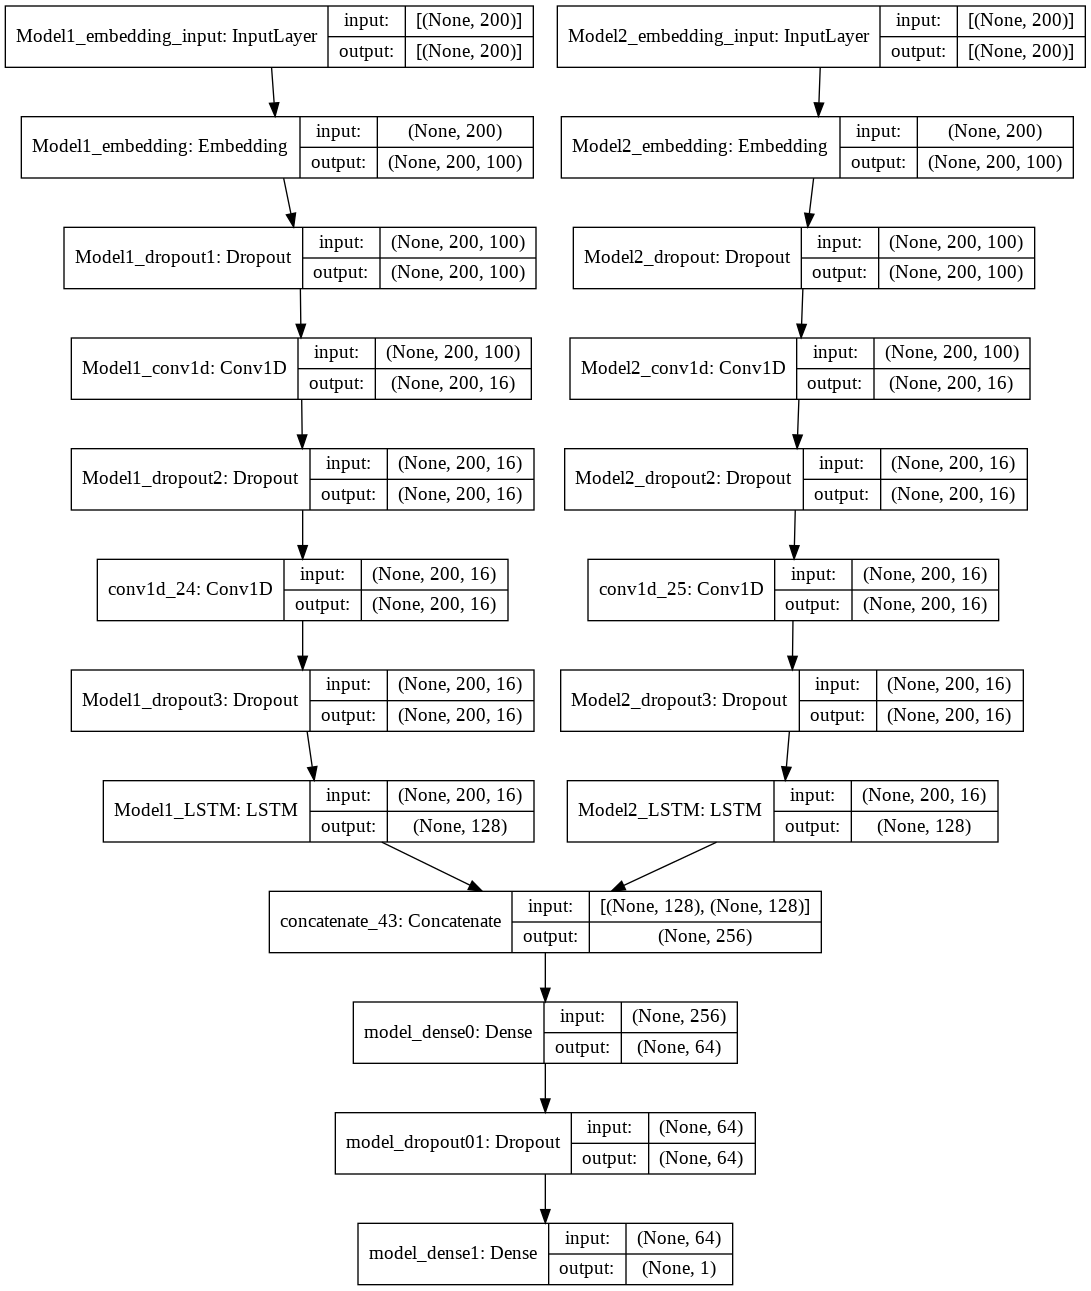

In [273]:
plot_model(model,show_shapes=True, expand_nested=True)

In [274]:
model.compile(loss='mean_squared_error',
                  optimizer=Adam(lr=learning_rate))

In [275]:
model.fit([x_train,x_train],y_train,epochs=3)

Epoch 1/3
53/53 [==============================] - 39s 681ms/step - loss: 0.1398
Epoch 2/3
53/53 [==============================] - 36s 683ms/step - loss: 0.0500
Epoch 3/3
53/53 [==============================] - 36s 674ms/step - loss: 0.0388


In [218]:
x_train.shape, y_train.shape

((1689, 200), (1689,))

In [282]:
save_best_weights = 'question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
                    deeper,wider,learning_rate,dropout)

In [284]:
save_best_weights 

'question_pairs_weights_deeper=True_wider=True_lr=0.0001_dropout=0.5.h5'

In [285]:
filepath="weights-improvement-{epoch:02d}-{loss:.2f}.hdf5"

callbacks = [ModelCheckpoint(filepath=filepath,  monitor='val_loss', save_best_only=True),
                             EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                             ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=3)]

In [287]:
history = model.fit([x_train,x_train],
                                    y_train,
                                    batch_size=128,
                                    epochs=10,
                                    validation_split=0.15,
                                    verbose=True,
                                    shuffle=True,
                                    callbacks = callbacks)

Epoch 1/10
12/12 [==============================] - 9s 793ms/step - loss: 0.0327 - val_loss: 0.0614
Epoch 2/10
12/12 [==============================] - 8s 709ms/step - loss: 0.0291 - val_loss: 0.0635
Epoch 3/10
12/12 [==============================] - 9s 725ms/step - loss: 0.0283 - val_loss: 0.0591
Epoch 4/10
12/12 [==============================] - 9s 715ms/step - loss: 0.0283 - val_loss: 0.0585
Epoch 5/10
12/12 [==============================] - 8s 702ms/step - loss: 0.0261 - val_loss: 0.0508
Epoch 6/10
12/12 [==============================] - 9s 715ms/step - loss: 0.0255 - val_loss: 0.0493
Epoch 7/10
12/12 [==============================] - 8s 700ms/step - loss: 0.0247 - val_loss: 0.0535
Epoch 8/10
12/12 [==============================] - 8s 699ms/step - loss: 0.0239 - val_loss: 0.0407
Epoch 9/10
12/12 [==============================] - 9s 730ms/step - loss: 0.0248 - val_loss: 0.0453
Epoch 10/10
12/12 [==============================] - 9s 718ms/step - loss: 0.0244 - val_loss: 0.0431

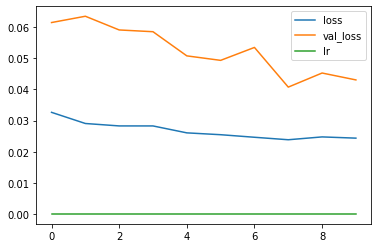

In [289]:
pd.DataFrame(history.history).plot()

In [120]:
from keras.utils import plot_model

In [290]:
# Make predictions with the best weights
deeper=False
wider=False
dropout=0.3
learning_Rate = 0.001
# Need to rebuild model in case it is different from the model that was trained most recently.
# model = build_model()

# model.load_weights('./question_pairs_weights_deeper={}_wider={}_lr={}_dropout={}.h5'.format(
#                     deeper,wider,learning_rate,dropout))
predictions = model.predict([x_test,x_test], verbose = True)

10/10 [==============================] - 1s 82ms/step


In [ ]:
# Compare testing loss to training and validating loss
mse(y_test, predictions)

0.0073422919167846195

In [291]:
mse(y_test, predictions)

0.042536466481333

In [293]:
def unnormalize(price):
    '''Revert values to their unnormalized amounts'''
    price = price*(max_price-min_price)+min_price
    return(price)

In [294]:
unnorm_predictions = []
for pred in predictions:
    unnorm_predictions.append(unnormalize(pred))
    
unnorm_y_test = []
for y in y_test:
    unnorm_y_test.append(unnormalize(y))

In [295]:
# Calculate the median absolute error for the predictions
mae(unnorm_y_test, unnorm_predictions)

309.3950798164078

In [296]:
print("Summary of actual opening price changes")
print(pd.DataFrame(unnorm_y_test, columns=[""]).describe())
print()
print("Summary of predicted opening price changes")
print(pd.DataFrame(unnorm_predictions, columns=[""]).describe())

Summary of actual opening price changes
                 
count  299.000000
mean    -7.094101
std    139.532324
min   -541.050782
25%    -87.465332
50%    -10.759766
75%     54.689941
max    673.139648

Summary of predicted opening price changes
                 
count  299.000000
mean  -326.142364
std     33.128276
min   -437.303070
25%   -347.675354
50%   -326.509033
75%   -305.913361
max   -224.418518


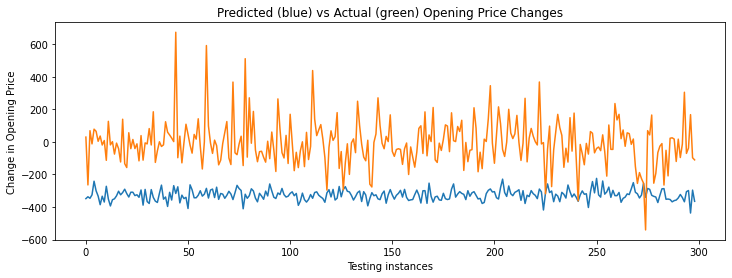

In [297]:
# Plot the predicted (blue) and actual (green) values
plt.figure(figsize=(12,4))
plt.plot(unnorm_predictions)
plt.plot(unnorm_y_test)
plt.title("Predicted (blue) vs Actual (green) Opening Price Changes")
plt.xlabel("Testing instances")
plt.ylabel("Change in Opening Price")
plt.show()

In [298]:
# Create lists to measure if opening price increased or decreased
direction_pred = []
for pred in unnorm_predictions:
    if pred >= 0:
        direction_pred.append(1)
    else:
        direction_pred.append(0)
direction_test = []
for value in unnorm_y_test:
    if value >= 0:
        direction_test.append(1)
    else:
        direction_test.append(0)

In [299]:
# Calculate if the predicted direction matched the actual direction
direction = acc(direction_test, direction_pred)
direction = round(direction,4)*100
print("Predicted values matched the actual direction {}% of the time.".format(direction))

Predicted values matched the actual direction 56.86% of the time.


As we can see from the data above, this model struggles to accurately predict the change in the opening price of the Dow Jones Instrustial Average. Given that its median average error is 74.15 and the interquartile range of the actual price change is 142.16 (87.47 + 54.69), this model is about as good as someone who knows the average price change of the Dow. 

I have a few ideas for why this model struggles:
- The market is arguably to be a random walk. Although there is some direction to its movements, there is still quite a bit of randomness to its movements.
- The news that we used might not be the most relevant. Perhaps it would have been better to use news relating to the 30 companies that make up the Dow.
- More information could have been included in the model, such as the previous day(s)'s change, the previous day(s)'s main headline(s). 
- Many people have worked on this task for years and companies spend millions of dollars to try to predict the movements of the market, so we shouldn't expect anything too great considering the small amount of data that we are working with and the simplicity of our model.

## Make Your Own Predictions

Below is the code necessary to make your own predictions. I found that the predictions are most accurate when there is no padding included in the input data. In the create_news variable, I have some default news that you can use, which is from April 30th, 2017. Just change the text to whatever you want, then see the impact your new headline will have.

In [300]:
def news_to_int(news):
    '''Convert your created news into integers'''
    ints = []
    for word in news.split():
        if word in vocab_to_int:
            ints.append(vocab_to_int[word])
        else:
            ints.append(vocab_to_int['<UNK>'])
    return ints

In [301]:
def padding_news(news):
    '''Adjusts the length of your created news to fit the model's input values.'''
    padded_news = news
    if len(padded_news) < max_daily_length:
        for i in range(max_daily_length-len(padded_news)):
            padded_news.append(vocab_to_int["<PAD>"])
    elif len(padded_news) > max_daily_length:
        padded_news = padded_news[:max_daily_length]
    return padded_news

In [303]:
# Default news that you can use
create_news = "Leaked document reveals Facebook conducted research to target emotionally vulnerable and insecure youth. \
               Woman says note from Chinese 'prisoner' was hidden in new purse. \
               21,000 AT&T workers poised for Monday strike \
               housands march against Trump climate policies in D.C., across USA \
               Kentucky judge won't hear gay adoptions because it's not in the child's \"best interest\" \
               Multiple victims shot in UTC area apartment complex \
               Drones Lead Police to Illegal Dumping in Riverside County | NBC Southern California \
               An 86-year-old Californian woman has died trying to fight a man who was allegedly sexually assaulting her 61-year-old friend. \
               Fyre Festival Named in $5Million+ Lawsuit after Stranding Festival-Goers on Island with Little Food, No Security. \
               The \"Greatest Show on Earth\" folds its tent for good \
               U.S.-led fight on ISIS have killed 352 civilians: Pentagon \
               Woman offers undercover officer sex for $25 and some Chicken McNuggets \
               Ohio bridge refuses to fall down after three implosion attempts \
               Jersey Shore MIT grad dies in prank falling from library dome \
               New York graffiti artists claim McDonald's stole work for latest burger campaign \
               SpaceX to launch secretive satellite for U.S. intelligence agency \
               Severe Storms Leave a Trail of Death and Destruction Through the U.S. \
               Hamas thanks N. Korea for its support against ‘Israeli occupation’ \
               Baker Police officer arrested for allegedly covering up details in shots fired investigation \
               Miami doctor’s call to broker during baby’s delivery leads to $33.8 million judgment \
               Minnesota man gets 15 years for shooting 5 Black Lives Matter protesters \
               South Australian woman facing possible 25 years in Colombian prison for drug trafficking \
               The Latest: Deal reached on funding government through Sept. \
               Russia flaunts Arctic expansion with new military bases"

clean_news = clean_text(create_news)

int_news = news_to_int(clean_news)

pad_news = padding_news(int_news)

pad_news = np.array(pad_news).reshape((1,-1))

pred = model.predict([pad_news,pad_news])

price_change = unnormalize(pred)

print("The Dow should open: {} from the previous open.".format(np.round(price_change[0][0],2)))

The Dow should open: -371.70001220703125 from the previous open.
